Create Mermaid Diagrams for Files Under Path

```mermaid
classDiagram
    class Animal
    Vehicle <|-- Car
```
```csharp
public class Animal{}
public class Vehicle{}
public class Car : Vehicle {}
```
Current Status
```mermaid
---
config:
  theme: redux-color
  themeVariables:
    primaryColor: "#00ff00"
  kanban:
    ticketBaseUrl: 'https://localhost/ticketing/#TICKET#'
---
kanban
  CB[Core Bugs]
  EB[Efficiency Bugs]
   
  IP[In progress -new, or returned-]  
    IP2[Track Ticket Progress-<br> using comments <br> eg.<br>var a = 5; //TT:01]@{priority: 'Medium', assigned: 'entitycs'}
    IP3[Create Agent flow for running checks on kanban vs. codebase ticket commenting]
  RD[Ready for Deploy]
    RD2[Combined OpenAPI+MCP Tested Concept]
  TR[Test Ready]
    TR1[System Prompt Tests]@{ ticket: TST:04, assigned: 'entitycs', priority: 'High' }
    IP1[UserValue -<br> directory path]@{priority: 'Very High', assigned: 'entitycs'}
  
  fin[Done]
    RD1[Basic Tested Concept]@{ assigned: 'entitycs' }
    fin1[Update Open WebUI to <br>LATEST~v0.6.38]@{priority: 'Very High'}
    fin3[-Hello World<br>Initial Tool Integration]@{priotity: 'Very High', ticket: FIN:01}
    fin2[Initiate Git Repo]@{priority: 'Low'}
```

In [1]:
# Initial, standalone OpenAPI tool implementation
import os
import re
from pydantic import BaseModel, Field


class Tools:
    # Admin‑level valves (global defaults)
    class Valves(BaseModel):
        folder_path: str = Field(
            "/workspace/src",
            description="Default path to the folder containing C# files",
        )
        max_files: int = Field(
            10,
            description="Maximum number of C# files to process per run",
        )
        pass

    # User‑level valves (per‑user overrides)
    class UserValves(BaseModel):
        include_interfaces: bool = Field(
            default=True,
            description="Whether to include interfaces in the Mermaid diagram",
        )
        include_abstracts: bool = Field(
            default=True,
            description="Whether to mark abstract classes in the Mermaid diagram",
        )
        pass

    def __init__(self):
        # Admin valves are available immediately
        self.valves = self.Valves()

    def _strip_generics(self, name: str) -> str:
        """Remove generic type arguments like <T> or <T1, T2> from a C# identifier."""
        return re.sub(r"<([^>]+)>", r"~\g<1>~", name)

    def batch_generate_mermaid(self, body: dict, __user__: dict) -> str:
        """
        Generate Mermaid diagrams from all C# files in the specified folder.
        Uses admin valves for defaults and user valves for per‑user overrides.
        """
        print(body)
        # Admin valve defaults
        folder_path = self.valves.folder_path

        # User valves (per user)
        user_valves = __user__["valves"]
        include_interfaces = user_valves.include_interfaces
        include_abstracts = user_valves.include_abstracts
        max_files = user_valves.max_files
        

        if not os.path.exists(folder_path):
            return f"ERROR: Folder not found at {folder_path}"

        output_blocks = []
        processed = 0

        for root, _, files in os.walk(folder_path):
            for file in files:
                if (
                    file.endswith(".cs")
                    and not file.endswith(".g.cs")
                    and "obj/" not in root
                ):
                    full_path = os.path.join(root, file)
                    rel_path = os.path.relpath(full_path, folder_path)
                    try:
                        diagram = self.generate_mermaid_from_csharp(
                            full_path,
                            include_interfaces=include_interfaces,
                            include_abstracts=include_abstracts,
                        )
                        block = f"### {rel_path}\n{diagram}"
                        output_blocks.append(block)
                        processed += 1
                        if processed >= max_files:
                            output_blocks.append(
                                f"... stopped at {max_files} files (out of many)"
                            )
                            break
                    except Exception as e:
                        output_blocks.append(
                            f"### {rel_path}\nError parsing {file}: {str(e)}"
                        )

            if processed >= max_files:
                break

        return "\n\n".join(output_blocks)

    def generate_mermaid_from_csharp(
        self,
        file_path: str,
        include_interfaces: bool = True,
        include_abstracts: bool = True,
    ) -> str:
        """
        Parse a C# file and generate a Mermaid diagram.
        :param file_path: path of the file from which chart is to be generated.
        :param include_interfaces: false to skip diagramming of interfaces.
        :param include_abstracts: false to skip diagramming of abstract classes.
        """
        if not os.path.exists(file_path):
            return f"ERROR: File not found at {file_path}"

        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        lines = code.split("\n")

        mermaid = [
            "```mermaid",
            "classDiagram",
            f"    %% File: {os.path.basename(file_path)}",
        ]

        class_pattern = re.compile(
            r"^\s*(public|internal|private|protected)?\s*(abstract|sealed)?\s*class\s+(\w+(?:<[^>]+>)?)(?:\s*:\s*([^}{]+))?"
        )
        interface_pattern = re.compile(
            r"^\s*(public|internal)?\s*interface\s+(\w+(?:<[^>]+>)?)"
        )

        for line in lines:
            line = line.strip()

            # Classes
            class_match = class_pattern.search(line)
            if class_match:
                modifiers = class_match.group(2) or ""
                class_name = self._strip_generics(class_match.group(3).strip())
                bases = class_match.group(4)

                mermaid.append(f"    class {class_name}")

                # Abstracts
                if include_abstracts and "abstract" in modifiers:
                    mermaid.append(f"    abstract_{class_name}")

                if bases:
                    for base in [b.strip() for b in bases.split(",")]:
                        if base and not base.startswith("{"):
                            clean_base = self._strip_generics(base.split()[-1])
                            mermaid.append(f"    {clean_base} <|-- {class_name}")

            # Interfaces
            if include_interfaces:
                iface_match = interface_pattern.search(line)
                if iface_match:
                    iface_name = self._strip_generics(iface_match.group(2).strip())
                    mermaid.append(f"    class interface_{iface_name}")

        mermaid.append("```")
        return "\n".join(mermaid)


####
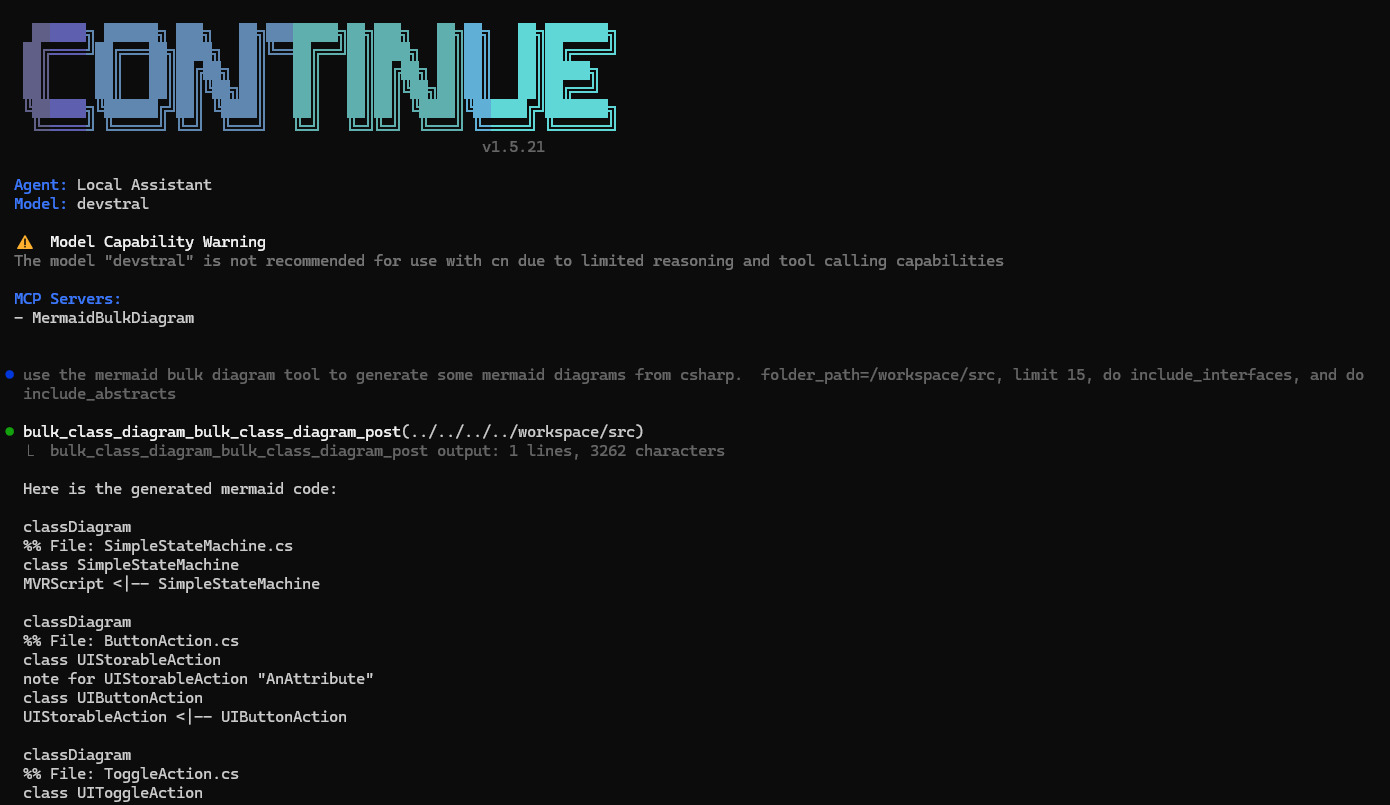
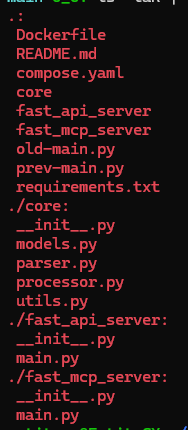

If using as a server, running docker, you can set up a test on port 8084, mount a directory (-v if using docker run), and run a test on the contained files

### Docker Compose
##### ./compose.yaml (inside openapi server directory)
```yaml
services:
  mermaid-classdiagram:
    build:
      context: ./servers/mermaid-class
    volumes:
      - /mnt/e/someWorkspace/src:/workspace/src
    ports:
      - 8084:8000
```

### Boilerplate Dockerfile
##### ./servers/[mermaid-class]/Dockerfile
```Dockerfile
# syntax=docker/dockerfile:1

# Comments are provided throughout this file to help you get started.
# If you need more help, visit the Dockerfile reference guide at
# https://docs.docker.com/go/dockerfile-reference/

# Want to help us make this template better? Share your feedback here: https://forms.gle/ybq9Krt8jtBL3iCk7

ARG PYTHON_VERSION=3.10.12
FROM python:${PYTHON_VERSION}-slim as base

# Prevents Python from writing pyc files.
ENV PYTHONDONTWRITEBYTECODE=1

# Keeps Python from buffering stdout and stderr to avoid situations where
# the application crashes without emitting any logs due to buffering.
ENV PYTHONUNBUFFERED=1

WORKDIR /app

# Create a non-privileged user that the app will run under.
# See https://docs.docker.com/go/dockerfile-user-best-practices/
ARG UID=10001
RUN adduser \
    --disabled-password \
    --gecos "" \
    --home "/nonexistent" \
    --shell "/sbin/nologin" \
    --no-create-home \
    --uid "${UID}" \
    appuser

# Download dependencies as a separate step to take advantage of Docker's caching.
# Leverage a cache mount to /root/.cache/pip to speed up subsequent builds.
# Leverage a bind mount to requirements.txt to avoid having to copy them into
# into this layer.
RUN --mount=type=cache,target=/root/.cache/pip \
    --mount=type=bind,source=requirements.txt,target=requirements.txt \
    python -m pip install -r requirements.txt

# Change the ownership of /app/data directory and its contents to appuser
RUN mkdir -p /app/data && touch /app/data/memory.json && chown -R ${UID}:${UID} /app/data

# Set a flag for the location of the database
ENV MEMORY_FILE_PATH="/app/data/memory.json"

# Switch to the non-privileged user to run the application.
USER appuser

# Copy the source code into the container (optional vs. using composer to mount specific directory)
COPY . .

# Expose the port that the application listens on.
EXPOSE 8000

# Run the application.
CMD uvicorn 'main:app' --host=0.0.0.0 --port=8000
```

### Requirements (Imports/pip)
##### ./servers/[mermaid-class]/requirements.txt, list your required imports (eg:)
```text
fastapi
uvicorn[standard]
pydantic
python-multipart
pytz
python-dateutil
```

### Main 
##### ./servers/[mermaid-class]/main.py
```python
from fastapi import FastAPI, Body
from fastapi.responses import Response
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
import os, pathlib, re

app = FastAPI(
    title="Mermaid Diagram API",
    version="1.0.0",
    description="Provides mermaid diagrams for csharp class source code",
)

origins = ["*"]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)
# ------------------------------------------------------------------------------
# Utility functions
# ------------------------------------------------------------------------------
def normalize_path(requested_path: str) -> pathlib.Path:
    requested = pathlib.Path(os.path.expand(requested_path)).resolve()
#    for allowed in ALLOWED_DIRECTORIES:
#    if true: #str(requested).lower().startswith(allowed.lower()): # Case-insensitive check
    return requested

def _strip_generics(name: str) -> str:
    """Remove generic type arguments like <T> or <T1, T2> from a C# identifier."""
    return re.sub(r"<([^>]+)>", r"~\g<1>~", name)

def generate_mermaid_from_csharp(
    file_path: str,
    include_interfaces: bool = True,
    include_abstracts: bool = True,
) -> str:
    """
    Parse a C# file and generate a Mermaid diagram.
    :param file_path: path of the file from which chart is to be generated.
    :param include_interfaces: false to skip diagramming of interfaces.
    :param include_abstracts: false to skip diagramming of abstract classes.
    """

    if not os.path.exists(file_path):
        return f"ERROR: File not found at {file_path}"

    with open(file_path, "r", encoding="utf-8") as f:
        code = f.read()

    lines = code.split("\n")

    mermaid = [
        "```mermaid",
        "classDiagram",
        f"    %% File: {os.path.basename(file_path)}",
    ]

    class_pattern = re.compile(
        r"^\s*(public|internal|private|protected)?\s*(abstract|sealed)?\s*class\s+(\w+(?:<[^>]+>)?)(?:\s*:\s*([^}{]+))?"
    )
    interface_pattern = re.compile(
        r"^\s*(public|internal)?\s*interface\s+(\w+(?:<[^>]+>)?)"
    )

    for line in lines:
        line = line.strip()

        # Classes
        class_match = class_pattern.search(line)
        if class_match:
            modifiers = class_match.group(2) or ""
            class_name = _strip_generics(class_match.group(3).strip())
            bases = class_match.group(4)

            mermaid.append(f"    class {class_name}")

            if include_abstracts and "abstract" in modifiers:
                mermaid.append(f"    abstract_{class_name}")

            if bases:
                for base in [b.strip() for b in bases.split(",")]:
                    if base and not base.startswith("{"):
                        clean_base = _strip_generics(base.split()[-1])
                        mermaid.append(f"    {clean_base} <|-- {class_name}")

        # Interfaces
        if include_interfaces:
            iface_match = interface_pattern.search(line)
            if iface_match:
                iface_name = _strip_generics(iface_match.group(2).strip())
                mermaid.append(f"    class interface_{iface_name}")

    mermaid.append("```")
    return "\n".join(mermaid)

# ---------------- Responses ----------------
class SuccessResponse(BaseModel):
    message: str = Field(..., description="Success message indicating the operation was completed.")

# ---------------- Requests ----------------
class CreateDiagramRequest(BaseModel):
    file_path: str = Field(default="/workspace/src/main.cs")
    include_interfaces: bool = True
    include_abstracts: bool = True

class BatchCreateClassDiagramRequest(BaseModel):
    folder_path: str = Field(default="/workspace/src")
    max_files: int = 10
    include_interfaces: bool = True
    include_abstracts: bool = True

# ---------------- Endpoints ----------------
@app.post("/bulk_class_diagram", response_model=SuccessResponse)
async def bulk_class_diagram(data: BatchCreateClassDiagramRequest = Body(...)):
    folder_path = data.folder_path
    if not os.path.exists(folder_path):
        return Response(content=f"ERROR: Folder not found at {folder_path}", media_type="text/markdown")

    output_blocks = []
    processed = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".cs") and not file.endswith(".g.cs") and "obj/" not in root:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, folder_path)
                diagram = generate_mermaid_from_csharp(full_path,
                                                      include_interfaces=data.include_interfaces,
                                                      include_abstracts=data.include_abstracts)
                block = f"### {rel_path}\n{diagram}"
                output_blocks.append(block)
                processed += 1
                if processed >= data.max_files:
                    output_blocks.append(f"... stopped at {data.max_files} files")
                    break
        if processed >= data.max_files:
            break

    markdown = "\n\n".join(output_blocks)
    return Response(content=markdown, media_type="text/markdown")

@app.post("/generate_diagram", response_model=SuccessResponse)
async def generate_diagram(data: CreateDiagramRequest = Body(...)):
    file_path = data.file_path
    if not os.path.exists(file_path):
        return Response(content=f"ERROR: File not found at {file_path}", media_type="text/markdown")

    diagram = generate_mermaid_from_csharp(file_path,
                                           include_interfaces=data.include_interfaces,
                                           include_abstracts=data.include_abstracts)
    block = f"### {file_path}\n{diagram}"
    return Response(content=block, media_type="text/markdown")

```